[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/classification_cats_vs_dogs_from_scratch.ipynb)

# Classification Kaggle Cats Vs Dogs

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
#!kill -9 -1

## Check Tensorflow Version

In [0]:
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'1.9.0-rc2'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras import layers, models, optimizers
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os, shutil

## Load Kaggle Dogs Dataset

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [7]:
# Check if the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jul  6 11:31 kaggle.json


In [0]:
# Install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /content/.kaggle/kaggle.json

In [10]:
# Download dataset from kaggle
!mkdir -p data/cats-vs-dogs && kaggle competitions download -c dogs-vs-cats -p data/cats-vs-dogs/

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 27.2MB/s]
 98%|████████████████████████████████████████ | 265M/271M [00:02<00:00, 153MB/s]
100%|█████████████████████████████████████████| 271M/271M [00:02<00:00, 133MB/s]
 99%|████████████████████████████████████████▌| 538M/543M [00:04<00:00, 158MB/s]
100%|█████████████████████████████████████████| 543M/543M [00:04<00:00, 141MB/s]


In [0]:
!mkdir data/cats-vs-dogs/orig_data && unzip data/cats-vs-dogs/train.zip -d data/cats-vs-dogs/orig_data/

In [0]:
orig_data_dir = '/content/data/cats-vs-dogs/orig_data/train'

In [0]:
base_dir = '/content/data/small-cats-vs-dogs'
os.mkdir(base_dir)

In [0]:
# Create Train, Validation and Test folders
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
# Prepare folders for cats and dogs  
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [16]:
!ls data/cats-vs-dogs/orig_data/train | head


cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


In [0]:
# create a smaller train, validation and test dataset from orig_data
train_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1000)]
train_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1000)]

val_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
val_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]

test_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
test_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]

In [0]:
for f_name in train_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(train_cats_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in val_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(validation_cats_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in test_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(test_cats_dir, f_name)
  shutil.copyfile(src, dst)

for f_name in train_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(train_dogs_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in val_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(validation_dogs_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in test_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(test_dogs_dir, f_name)
  shutil.copyfile(src, dst) 

In [32]:
len(os.listdir(train_cats_dir))

1000

In [33]:
len(os.listdir(train_dogs_dir))

1000

## Data Preparation 


In [0]:
train_data_gen = ImageDataGenerator(rescale=1.0/255)
val_data_gen = ImageDataGenerator(rescale=1.0/255)

In [35]:
train_data_generator = train_data_gen.flow_from_directory(train_dir,
                                                          target_size=(150, 150),
                                                          batch_size=20,
                                                          class_mode='binary')
val_data_generator = val_data_gen.flow_from_directory(validation_dir,
                                                      target_size=(150, 150),
                                                      batch_size=20,
                                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
for train_batch_data, train_batch_labels in train_data_generator:
  print(train_batch_data.shape, train_batch_labels.shape)
  break

(20, 150, 150, 3) (20,)


## Model

In [0]:
def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [0]:
model = create_model()

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Train the Model

In [40]:
model_history = model.fit_generator(train_data_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=val_data_generator,
                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 13s 131ms/step - loss: 0.7749 - acc: 0.5235 - val_loss: 0.6856 - val_acc: 0.5530
Epoch 2/30
100/100 [==============================] - 12s 116ms/step - loss: 0.6849 - acc: 0.5845 - val_loss: 0.6625 - val_acc: 0.5390
Epoch 3/30
100/100 [==============================] - 11s 114ms/step - loss: 0.6353 - acc: 0.6435 - val_loss: 0.6103 - val_acc: 0.6550
Epoch 4/30
 79/100 [======================>.......] - ETA: 1s - loss: 0.6067 - acc: 0.6943

100/100 [==============================] - 11s 113ms/step - loss: 0.5976 - acc: 0.7040 - val_loss: 0.5575 - val_acc: 0.7140
Epoch 5/30
100/100 [==============================] - 11s 114ms/step - loss: 0.5474 - acc: 0.7325 - val_loss: 0.5725 - val_acc: 0.6860
Epoch 6/30
100/100 [==============================] - 12s 115ms/step - loss: 0.4794 - acc: 0.7665 - val_loss: 0.6714 - val_acc: 0.6710
Epoch 7/30
 98/100 [============================>.] - ETA: 0s - loss: 0.4483 - acc: 0.7934

100/100 [==============================] - 11s 113ms/step - loss: 0.4477 - acc: 0.7945 - val_loss: 0.6057 - val_acc: 0.7170
Epoch 8/30
100/100 [==============================] - 11s 113ms/step - loss: 0.3888 - acc: 0.8320 - val_loss: 0.8656 - val_acc: 0.6680
Epoch 9/30
100/100 [==============================] - 11s 114ms/step - loss: 0.3128 - acc: 0.8600 - val_loss: 0.5990 - val_acc: 0.7410
Epoch 10/30
100/100 [==============================] - 11s 114ms/step - loss: 0.2796 - acc: 0.8890 - val_loss: 0.6795 - val_acc: 0.7310


Epoch 11/30
100/100 [==============================] - 11s 115ms/step - loss: 0.2165 - acc: 0.9040 - val_loss: 0.8178 - val_acc: 0.7350
Epoch 12/30
100/100 [==============================] - 11s 115ms/step - loss: 0.2054 - acc: 0.9300 - val_loss: 1.0584 - val_acc: 0.7230
Epoch 13/30
100/100 [==============================] - 11s 113ms/step - loss: 0.1334 - acc: 0.9450 - val_loss: 1.2535 - val_acc: 0.6910
Epoch 14/30
 77/100 [======================>.......] - ETA: 1s - loss: 0.1318 - acc: 0.9513

100/100 [==============================] - 11s 113ms/step - loss: 0.1267 - acc: 0.9515 - val_loss: 1.2788 - val_acc: 0.7290
Epoch 15/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0894 - acc: 0.9675 - val_loss: 1.3180 - val_acc: 0.7430
Epoch 16/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0777 - acc: 0.9730 - val_loss: 1.4745 - val_acc: 0.7240
Epoch 17/30
 95/100 [===========================>..] - ETA: 0s - loss: 0.0906 - acc: 0.9711

100/100 [==============================] - 11s 115ms/step - loss: 0.0877 - acc: 0.9720 - val_loss: 1.6764 - val_acc: 0.7460
Epoch 18/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0620 - acc: 0.9860 - val_loss: 1.5153 - val_acc: 0.7300
Epoch 19/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0658 - acc: 0.9780 - val_loss: 1.9745 - val_acc: 0.7090
Epoch 20/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0540 - acc: 0.9805 - val_loss: 1.8139 - val_acc: 0.7450


Epoch 21/30
100/100 [==============================] - 12s 117ms/step - loss: 0.1005 - acc: 0.9750 - val_loss: 1.4718 - val_acc: 0.7490
Epoch 22/30
100/100 [==============================] - 12s 121ms/step - loss: 0.0661 - acc: 0.9825 - val_loss: 2.0171 - val_acc: 0.7120
Epoch 23/30
100/100 [==============================] - 11s 115ms/step - loss: 0.1090 - acc: 0.9775 - val_loss: 1.7726 - val_acc: 0.7280
Epoch 24/30
 76/100 [=====================>........] - ETA: 1s - loss: 0.0556 - acc: 0.9822

100/100 [==============================] - 11s 113ms/step - loss: 0.0519 - acc: 0.9830 - val_loss: 1.8269 - val_acc: 0.7260
Epoch 25/30
100/100 [==============================] - 11s 115ms/step - loss: 0.1105 - acc: 0.9835 - val_loss: 2.2178 - val_acc: 0.7370
Epoch 26/30
100/100 [==============================] - 12s 116ms/step - loss: 0.0584 - acc: 0.9845 - val_loss: 2.5442 - val_acc: 0.7090
Epoch 27/30
 91/100 [==========================>...] - ETA: 0s - loss: 0.0621 - acc: 0.9830

100/100 [==============================] - 11s 115ms/step - loss: 0.0593 - acc: 0.9835 - val_loss: 2.4357 - val_acc: 0.7020
Epoch 28/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0793 - acc: 0.9825 - val_loss: 2.2134 - val_acc: 0.7250
Epoch 29/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0482 - acc: 0.9880 - val_loss: 1.8292 - val_acc: 0.7450
Epoch 30/30
100/100 [==============================] - 12s 115ms/step - loss: 0.0833 - acc: 0.9810 - val_loss: 1.9673 - val_acc: 0.7220


In [0]:
model.save('small-cats-vs-dogs-1.h5')

## Plot Train and Validation loss and accuracy

In [0]:
train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

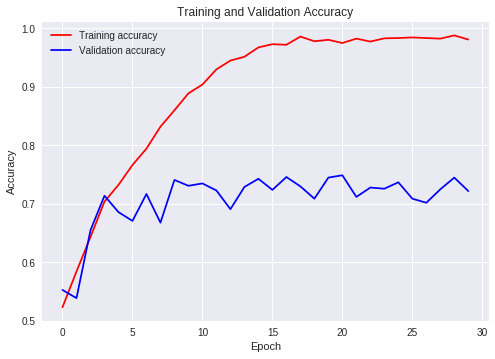

In [43]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

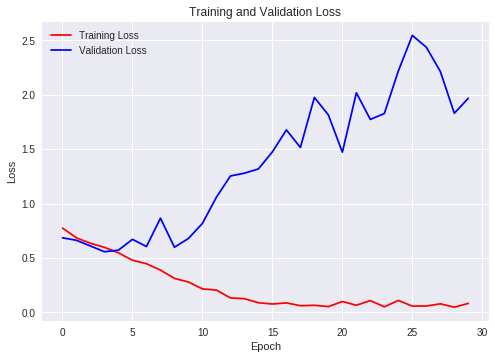

In [44]:
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Data augmentation to improve the model as we are using a small dataset



In [0]:
data_generator = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

### Check the augmentation of the images

In [0]:
f_names = [os.path.join(train_dogs_dir, f_name) for f_name in os.listdir(train_dogs_dir)]

In [0]:
img_pth = f_names[1]
img = image.load_img(img_pth, target_size=(150, 150))
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)

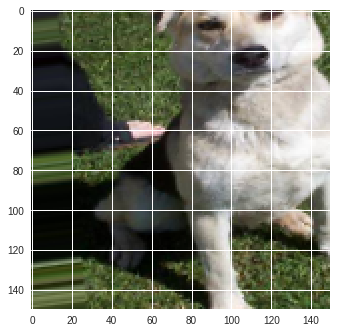

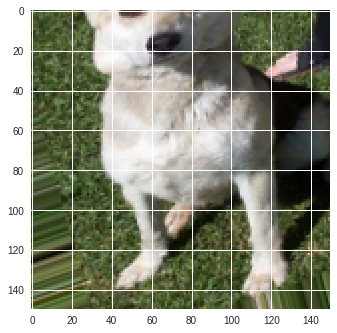

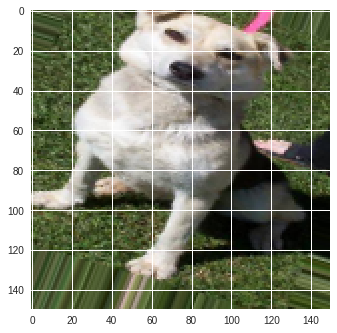

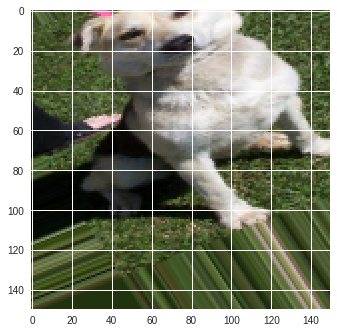

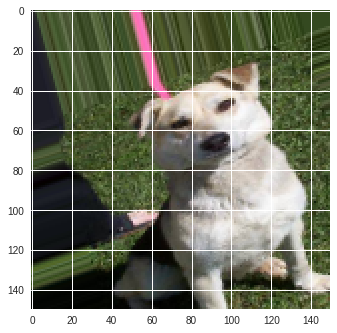

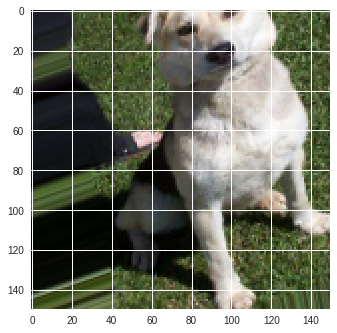

In [54]:
for idx, batch in enumerate(data_generator.flow(img_arr, batch_size=1)):
  plt.figure(idx)
  img_plot = plt.imshow(image.array_to_img(batch[0]))
  if idx > 4:
    break

In [0]:
# add regurization in the previous model using dropout
def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [0]:
model = create_model()

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
train_data_gen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1.0/255)

In [71]:
train_data_generator = train_data_gen.flow_from_directory(train_dir,
                                                          target_size=(150, 150),
                                                          batch_size=32,
                                                          class_mode='binary')
val_data_generator = val_data_gen.flow_from_directory(validation_dir,
                                                      target_size=(150, 150),
                                                      batch_size=32,
                                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [72]:
model_history = model.fit_generator(train_data_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=val_data_generator,
                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 36s 362ms/step - loss: 0.7253 - acc: 0.5181 - val_loss: 0.6859 - val_acc: 0.5133
Epoch 2/30
100/100 [==============================] - 33s 330ms/step - loss: 0.7029 - acc: 0.5409 - val_loss: 0.6590 - val_acc: 0.6187
Epoch 3/30
100/100 [==============================] - 33s 330ms/step - loss: 0.6958 - acc: 0.5866 - val_loss: 0.6384 - val_acc: 0.6631
Epoch 4/30
 64/100 [==================>...........] - ETA: 8s - loss: 0.6467 - acc: 0.6338

100/100 [==============================] - 33s 328ms/step - loss: 0.6477 - acc: 0.6366 - val_loss: 0.6041 - val_acc: 0.6720
Epoch 5/30
100/100 [==============================] - 31s 315ms/step - loss: 0.6332 - acc: 0.6509 - val_loss: 0.6265 - val_acc: 0.6383
Epoch 6/30
100/100 [==============================] - 35s 355ms/step - loss: 0.6358 - acc: 0.6506 - val_loss: 0.5812 - val_acc: 0.7056
Epoch 7/30
 83/100 [=======================>......] - ETA: 4s - loss: 0.6080 - acc: 0.6653

100/100 [==============================] - 35s 352ms/step - loss: 0.6081 - acc: 0.6644 - val_loss: 0.6054 - val_acc: 0.6548
Epoch 8/30
100/100 [==============================] - 35s 352ms/step - loss: 0.6005 - acc: 0.6931 - val_loss: 2.4494 - val_acc: 0.5121
Epoch 9/30
100/100 [==============================] - 35s 349ms/step - loss: 0.5987 - acc: 0.6925 - val_loss: 0.5596 - val_acc: 0.7081
Epoch 10/30
 85/100 [========================>.....] - ETA: 4s - loss: 0.5801 - acc: 0.6923

100/100 [==============================] - 34s 343ms/step - loss: 0.5820 - acc: 0.6875 - val_loss: 0.5254 - val_acc: 0.7386
Epoch 11/30
100/100 [==============================] - 36s 357ms/step - loss: 0.5891 - acc: 0.6981 - val_loss: 0.5115 - val_acc: 0.7456
Epoch 12/30
100/100 [==============================] - 35s 352ms/step - loss: 0.5572 - acc: 0.7059 - val_loss: 0.5151 - val_acc: 0.7322
Epoch 13/30
 84/100 [========================>.....] - ETA: 4s - loss: 0.5627 - acc: 0.7195

100/100 [==============================] - 35s 352ms/step - loss: 0.5604 - acc: 0.7184 - val_loss: 0.5201 - val_acc: 0.7392
Epoch 14/30
100/100 [==============================] - 34s 341ms/step - loss: 0.5501 - acc: 0.7275 - val_loss: 0.5152 - val_acc: 0.7367
Epoch 15/30
100/100 [==============================] - 34s 339ms/step - loss: 0.5634 - acc: 0.7144 - val_loss: 0.4523 - val_acc: 0.7849
Epoch 16/30
 86/100 [========================>.....] - ETA: 3s - loss: 0.5388 - acc: 0.7235

100/100 [==============================] - 35s 348ms/step - loss: 0.5362 - acc: 0.7269 - val_loss: 0.5231 - val_acc: 0.7310
Epoch 17/30
100/100 [==============================] - 33s 326ms/step - loss: 0.5319 - acc: 0.7391 - val_loss: 0.4864 - val_acc: 0.7494
Epoch 18/30
100/100 [==============================] - 37s 373ms/step - loss: 0.5258 - acc: 0.7488 - val_loss: 0.4574 - val_acc: 0.7779
Epoch 19/30
 86/100 [========================>.....] - ETA: 3s - loss: 0.5082 - acc: 0.7547

100/100 [==============================] - 35s 345ms/step - loss: 0.5112 - acc: 0.7516 - val_loss: 0.4681 - val_acc: 0.7824
Epoch 20/30
100/100 [==============================] - 35s 348ms/step - loss: 0.5227 - acc: 0.7478 - val_loss: 0.5419 - val_acc: 0.7069
Epoch 21/30
100/100 [==============================] - 35s 347ms/step - loss: 0.5003 - acc: 0.7650 - val_loss: 0.4466 - val_acc: 0.7893
Epoch 22/30
 85/100 [========================>.....] - ETA: 3s - loss: 0.4965 - acc: 0.7632

100/100 [==============================] - 33s 331ms/step - loss: 0.4954 - acc: 0.7594 - val_loss: 0.4834 - val_acc: 0.7684
Epoch 23/30
100/100 [==============================] - 37s 367ms/step - loss: 0.4862 - acc: 0.7713 - val_loss: 0.4852 - val_acc: 0.7589
Epoch 24/30
100/100 [==============================] - 35s 352ms/step - loss: 0.4778 - acc: 0.7781 - val_loss: 0.4169 - val_acc: 0.8122
Epoch 25/30
 85/100 [========================>.....] - ETA: 4s - loss: 0.4708 - acc: 0.7824

100/100 [==============================] - 35s 347ms/step - loss: 0.4732 - acc: 0.7819 - val_loss: 0.4873 - val_acc: 0.7576
Epoch 26/30
100/100 [==============================] - 34s 345ms/step - loss: 0.4764 - acc: 0.7756 - val_loss: 0.4477 - val_acc: 0.7944
Epoch 27/30
100/100 [==============================] - 34s 344ms/step - loss: 0.4822 - acc: 0.7659 - val_loss: 0.4097 - val_acc: 0.8122
Epoch 28/30
 85/100 [========================>.....] - ETA: 4s - loss: 0.4735 - acc: 0.7838

100/100 [==============================] - 36s 355ms/step - loss: 0.4670 - acc: 0.7869 - val_loss: 0.4614 - val_acc: 0.7798
Epoch 29/30
100/100 [==============================] - 35s 347ms/step - loss: 0.4647 - acc: 0.7787 - val_loss: 0.5403 - val_acc: 0.7278
Epoch 30/30
100/100 [==============================] - 34s 340ms/step - loss: 0.4676 - acc: 0.7878 - val_loss: 0.4112 - val_acc: 0.8135


### Plot results after augmentation and regularization

In [0]:
model.save('small-cats-vs-dogs-2.h5')

In [0]:
train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

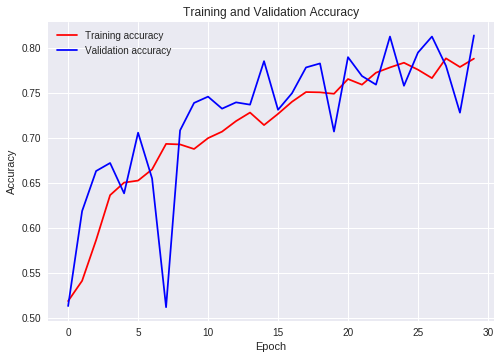

In [75]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

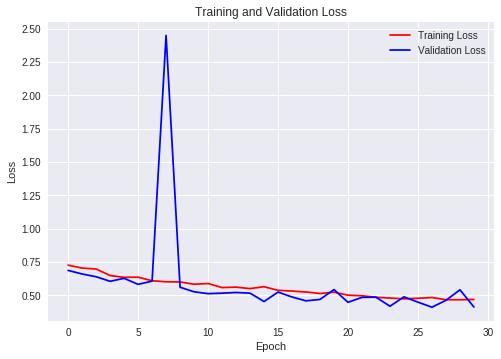

In [76]:
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()